# Semantic Segmentation vs Object Detection 트래킹 비교

이 노트북은 원본 GridClustering 구조를 유지하면서 Semantic Segmentation 기반 트래킹과 순정 YOLO 기반 Object Detection의 성능을 비교합니다.

In [1]:
# 필요한 라이브러리 설치
!pip install opencv-python numpy torch matplotlib tqdm scikit-image psutil transformers pandas ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.1/994.1 kB 61.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.measure import regionprops, label
import random
import time
import psutil
import math
import pandas as pd
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
from ultralytics import YOLO

# 랜덤 시드 설정
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 8방위 방향 계산 함수

객체의 이동 방향을 8방위(N, NE, E, SE, S, SW, W, NW)로 계산하는 함수들을 정의합니다.

In [3]:
def calculate_8_direction(dx, dy):
    """
    Calculate the direction based on 8 cardinal directions:
    N, NE, E, SE, S, SW, W, NW

    Args:
        dx: Change in x-coordinate
        dy: Change in y-coordinate (note: in image coordinates, y increases downward)

    Returns:
        String representing the direction
    """
    # Calculate angle in radians and convert to degrees
    angle = math.atan2(dy, dx) * 180 / math.pi

    # Adjust angle to be between 0 and 360 degrees
    if angle < 0:
        angle += 360

    # Define direction based on angle
    if 22.5 <= angle < 67.5:
        return "SE"  # South-East
    elif 67.5 <= angle < 112.5:
        return "S"   # South
    elif 112.5 <= angle < 157.5:
        return "SW"  # South-West
    elif 157.5 <= angle < 202.5:
        return "W"   # West
    elif 202.5 <= angle < 247.5:
        return "NW"  # North-West
    elif 247.5 <= angle < 292.5:
        return "N"   # North
    elif 292.5 <= angle < 337.5:
        return "NE"  # North-East
    else:  # angle < 22.5 or angle >= 337.5
        return "E"   # East

def calculate_direction_accuracy(directions):
    """
    Calculate the accuracy of direction tracking

    Args:
        directions: List of direction strings

    Returns:
        Dictionary with dominant direction and accuracy percentage
    """
    if not directions:
        return {
            'dominant_direction': 'N/A',
            'direction_accuracy': 0.0
        }

    # Count occurrences of each direction
    direction_counts = {}
    for direction in directions:
        if direction in direction_counts:
            direction_counts[direction] += 1
        else:
            direction_counts[direction] = 1

    # Find the most common direction
    dominant_direction = max(direction_counts, key=direction_counts.get)
    correct_count = direction_counts[dominant_direction]
    accuracy = (correct_count / len(directions)) * 100

    return {
        'dominant_direction': dominant_direction,
        'direction_accuracy': round(accuracy, 2)
    }

## 1. GridClustering 원본 구현

원본 GridClustering 구현을 최대한 유지하면서 8방위 방향 시스템을 추가합니다.

In [4]:
class GridClustering:
    def __init__(self, grid_size=50, min_samples=3):
        self.grid_size = grid_size
        self.min_samples = min_samples
        self.tracks = []
        self.next_id = 0
        self.bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)
        self.roi_mask = None
        self.direction_data = {}  # 트랙별 방향 데이터 저장

    def set_roi(self, roi_mask):
        """ROI 마스크 설정 (처음에 한 번만 설정)"""
        self.roi_mask = roi_mask

    def detect_moving_objects(self, frame):
        """배경 차분을 사용하여 움직이는 객체 검출"""
        # 배경 차분 적용
        fg_mask = self.bg_subtractor.apply(frame)
        fg_mask[fg_mask == 127] = 0  # 그림자 제거

        # 그림자 및 헤드라이트 감지
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        shadow_mask = (v < 0.3 * 255).astype(np.uint8) * 255
        highlight_mask = ((v > 220) & (s < 50)).astype(np.uint8) * 255

        fg_mask[shadow_mask > 0] = fg_mask[shadow_mask > 0] * 0.7
        fg_mask[highlight_mask > 0] = fg_mask[highlight_mask > 0] * 0.6

        # ROI 마스크가 있으면 적용
        if self.roi_mask is not None:
            moving_objects_mask = np.zeros_like(fg_mask)
            moving_objects_mask[self.roi_mask > 0] = fg_mask[self.roi_mask > 0]
        else:
            moving_objects_mask = fg_mask

        # 모폴로지 연산으로 노이즈 제거
        kernel = np.ones((5, 5), np.uint8)
        moving_objects_mask = cv2.morphologyEx(moving_objects_mask, cv2.MORPH_OPEN, kernel)
        moving_objects_mask = cv2.morphologyEx(moving_objects_mask, cv2.MORPH_CLOSE, kernel)

        # 레이블링
        labeled_mask, num_labels = label(moving_objects_mask > 0, return_num=True, connectivity=2)

        return labeled_mask, fg_mask

    def extract_clusters(self, frame, labeled_mask, min_area=100):
        """레이블링된 마스크에서 클러스터 추출"""
        regions = regionprops(labeled_mask)
        clusters = []

        for region in regions:
            if region.area < min_area:  # 작은 영역 필터링
                continue

            # 바운딩 박스 계산
            minr, minc, maxr, maxc = region.bbox
            x1, y1, x2, y2 = minc, minr, maxc, maxr

            # 중심점 계산
            cy, cx = region.centroid

            clusters.append({
                'bbox': [x1, y1, x2, y2],
                'centroid': [cx, cy],
                'area': region.area
            })

        return clusters

    def match_clusters(self, prev_clusters, curr_clusters, max_dist=50, area_similarity_threshold=0.5):
        """이전 프레임과 현재 프레임의 클러스터 매칭"""
        matches = []
        for curr in curr_clusters:
            curr_cx, curr_cy = curr['centroid']
            curr_area = curr['area']
            min_dist = float('inf')
            best_match = None
            for prev in prev_clusters:
                prev_cx, prev_cy = prev['centroid']
                prev_area = prev['area']
                area_ratio = min(prev_area, curr_area) / max(prev_area, curr_area)
                if area_ratio < area_similarity_threshold:
                    continue
                dist = np.sqrt((curr_cx - prev_cx)**2 + (curr_cy - prev_cy)**2)
                if dist < min_dist and dist < max_dist:
                    min_dist = dist
                    best_match = prev
            matches.append((best_match, curr))
        return matches

    def update_tracks(self, matches, frame_count, max_trace_length=50, trace_duration=30, stationary_threshold=3):
        """트랙 업데이트"""
        # 첫 프레임이면 모든 클러스터를 새 트랙으로 초기화
        if not self.tracks:
            for _, curr in matches:
                self.tracks.append([{
                    'id': self.next_id,
                    'centroid': curr['centroid'],
                    'bbox': curr['bbox'],
                    'area': curr['area'],
                    'frame': frame_count,
                    'stationary_count': 0
                }])
                self.next_id += 1
            return

        # 매칭 결과에 따라 트랙 업데이트
        updated_track_ids = set()
        for prev, curr in matches:
            if prev is None:  # 새 클러스터
                self.tracks.append([{
                    'id': self.next_id,
                    'centroid': curr['centroid'],
                    'bbox': curr['bbox'],
                    'area': curr['area'],
                    'frame': frame_count,
                    'stationary_count': 0
                }])
                self.next_id += 1
            else:  # 기존 트랙 업데이트
                track_id = prev['id']
                track_idx = None
                for i, track in enumerate(self.tracks):
                    if track and track[-1]['id'] == track_id:
                        track_idx = i
                        break

                if track_idx is not None:
                    # 정지 상태 확인
                    prev_cx, prev_cy = prev['centroid']
                    curr_cx, curr_cy = curr['centroid']
                    dist = np.sqrt((curr_cx - prev_cx)**2 + (curr_cy - prev_cy)**2)

                    stationary_count = prev['stationary_count']
                    if dist < stationary_threshold:
                        stationary_count += 1
                    else:
                        stationary_count = 0

                    # 트랙 업데이트
                    self.tracks[track_idx].append({
                        'id': track_id,
                        'centroid': curr['centroid'],
                        'bbox': curr['bbox'],
                        'area': curr['area'],
                        'frame': frame_count,
                        'stationary_count': stationary_count
                    })

                    # 트랙 길이 제한
                    if len(self.tracks[track_idx]) > max_trace_length:
                        self.tracks[track_idx] = self.tracks[track_idx][-max_trace_length:]

                    # 방향 데이터 업데이트 (8방위)
                    if len(self.tracks[track_idx]) >= 2:
                        dx = curr['centroid'][0] - prev['centroid'][0]
                        dy = curr['centroid'][1] - prev['centroid'][1]
                        direction = calculate_8_direction(dx, dy)

                        if track_id not in self.direction_data:
                            self.direction_data[track_id] = []
                        self.direction_data[track_id].append(direction)

                    updated_track_ids.add(track_idx)

        # 오래된 트랙 제거
        for i in range(len(self.tracks) - 1, -1, -1):
            if i not in updated_track_ids and self.tracks[i] and frame_count - self.tracks[i][-1]['frame'] > trace_duration:
                self.tracks[i] = None

        # None 값 제거
        self.tracks = [track for track in self.tracks if track is not None]

    def cluster_tracks_by_grid(self):
        """트랙을 그리드 기반으로 클러스터링"""
        if not self.tracks:
            return [], []

        # 그리드 기반 클러스터링을 위한 딕셔너리
        grid_to_tracks = {}
        track_indices = []

        for idx, track in enumerate(self.tracks):
            if len(track) < 2:
                continue

            # 트랙의 시작 위치 (첫 번째 클러스터의 중심점)
            start_x, start_y = track[0]['centroid']

            # 그리드 셀 계산
            grid_x = int(start_x // self.grid_size)
            grid_y = int(start_y // self.grid_size)
            grid_key = (grid_x, grid_y)

            # 그리드 셀에 트랙 추가
            if grid_key not in grid_to_tracks:
                grid_to_tracks[grid_key] = []
            grid_to_tracks[grid_key].append(idx)
            track_indices.append(idx)

        # 클러스터 레이블 생성
        labels = [-1] * len(self.tracks)
        current_label = 0
        valid_tracks = []

        for grid_key, track_ids in grid_to_tracks.items():
            if len(track_ids) >= self.min_samples:
                for idx in track_ids:
                    labels[idx] = current_label
                valid_tracks.extend([self.tracks[idx] for idx in track_ids])
                current_label += 1

        valid_labels = [labels[idx] for idx in track_indices if labels[idx] != -1]
        return valid_tracks, valid_labels

    def get_direction_accuracy(self):
        """8방위 방향 정확도 계산"""
        direction_results = {}

        for track_id, directions in self.direction_data.items():
            if len(directions) < 2:
                continue

            direction_results[track_id] = calculate_direction_accuracy(directions)

        return direction_results

    def process_frame(self, frame, frame_count):
        """프레임 처리"""
        # 움직이는 객체 검출
        labeled_mask, fg_mask = self.detect_moving_objects(frame)

        # 클러스터 추출
        curr_clusters = self.extract_clusters(frame, labeled_mask)

        # 이전 클러스터 가져오기
        prev_clusters = []
        for track in self.tracks:
            if track:
                prev_clusters.append(track[-1])

        # 클러스터 매칭
        matches = self.match_clusters(prev_clusters, curr_clusters)

        # 트랙 업데이트
        self.update_tracks(matches, frame_count)

        return labeled_mask, fg_mask

    def draw_tracks(self, frame, color_by_direction=True):
        """트랙 시각화"""
        vis_frame = frame.copy()

        # ROI 표시
        if self.roi_mask is not None:
            roi_contours, _ = cv2.findContours(self.roi_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_frame, roi_contours, -1, (0, 0, 255), 2)

        # 방향별 색상 설정
        direction_colors = {
            "N": (255, 0, 0),     # 빨강
            "NE": (255, 128, 0),  # 주황
            "E": (255, 255, 0),   # 노랑
            "SE": (128, 255, 0),  # 연두
            "S": (0, 255, 0),     # 초록
            "SW": (0, 255, 128),  # 청록
            "W": (0, 128, 255),   # 하늘
            "NW": (0, 0, 255)     # 파랑
        }

        # 트랙 그리기
        for track in self.tracks:
            if not track or len(track) < 2:
                continue

            track_id = track[0]['id']

            # 방향 계산
            first_centroid = track[0]['centroid']
            last_centroid = track[-1]['centroid']
            dx = last_centroid[0] - first_centroid[0]
            dy = last_centroid[1] - first_centroid[1]
            direction = calculate_8_direction(dx, dy)

            # 색상 설정
            if color_by_direction:
                color = direction_colors.get(direction, (255, 255, 255))
            else:
                # 트랙 ID에 따라 색상 설정
                color = ((track_id * 50) % 255, (track_id * 100) % 255, (track_id * 150) % 255)

            # 트랙 그리기
            points = []
            for detection in track:
                cx, cy = detection['centroid']
                points.append((int(cx), int(cy)))

            # 경로 그리기 (그라데이션 효과)
            for i in range(1, len(points)):
                alpha = 0.5 + 0.5 * (i / len(points))  # 투명도 그라데이션
                thickness = 1 + int(2 * (i / len(points)))  # 두께 그라데이션
                cv2.line(vis_frame, points[i-1], points[i], color, thickness)

            # 현재 위치 표시
            cx, cy = points[-1]
            cv2.circle(vis_frame, (cx, cy), 5, color, -1)

            # 바운딩 박스 그리기
            x1, y1, x2, y2 = track[-1]['bbox']
            cv2.rectangle(vis_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

            # 트랙 ID 및 방향 표시
            text = f"ID:{track_id} {direction}"
            cv2.putText(vis_frame, text, (int(cx) + 10, int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        return vis_frame

## 2. Semantic Segmentation 기반 트래킹 구현

Semantic Segmentation 모델을 사용하여 ROI를 설정하고 객체를 추적하는 함수들을 정의합니다.

In [11]:
# 세그멘테이션 모델 설정
def setup_segmentation_model():
    model_name = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
    print(f"모델 '{model_name}' 로드 중...")
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForSemanticSegmentation.from_pretrained(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    cityscapes_classes = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
                          'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
                          'truck', 'bus', 'train', 'motorcycle', 'bicycle']
    road_classes = [i for i, name in enumerate(cityscapes_classes) if name in ['road', 'sidewalk']]
    vehicle_classes = [i for i, name in enumerate(cityscapes_classes) if name in ['car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']]

    print(f"도로 클래스: {[(i, cityscapes_classes[i]) for i in road_classes]}")
    print(f"탈것 클래스: {[(i, cityscapes_classes[i]) for i in vehicle_classes]}")
    print(f"사용 중인 디바이스: {device}")
    return model, image_processor, device, road_classes, vehicle_classes, cityscapes_classes

# 첫 프레임에서 ROI 설정
def get_first_frame_roi(video_path, model, image_processor, device, road_classes, vehicle_classes, stabilization_frames=15):
    """
    첫 프레임에서 ROI를 설정하고 배경 모델을 안정화하는 함수

    Args:
        video_path: 비디오 파일 경로
        model: 세그멘테이션 모델
        image_processor: 이미지 프로세서
        device: 디바이스
        road_classes: 도로 클래스 인덱스
        vehicle_classes: 차량 클래스 인덱스
        stabilization_frames: 안정화를 위한 프레임 수

    Returns:
        ROI 마스크, 프레임 리스트
    """
    if not os.path.exists(video_path):
        print("비디오 파일이 없습니다.")
        return None, None

    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        print("Error: 프레임을 읽을 수 없습니다.")
        cap.release()
        return None, None

    print("첫 프레임에서 도로와 탈것 세그멘테이션 수행 중...")
    roi_mask = segment_frame(model, image_processor, frame, device, road_classes, vehicle_classes)

    # 추가 프레임 읽기 (안정화 목적)
    frames = [frame]
    for i in range(stabilization_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    print("첫 프레임에서 고정 ROI 설정 완료!")
    print(f"ROI 영역 비율: {np.sum(roi_mask > 0) / (roi_mask.shape[0] * roi_mask.shape[1]) * 100:.2f}%")

    return roi_mask, frames

# 세그멘테이션 기반 ROI 생성
def segment_frame(model, image_processor, frame, device, road_classes, vehicle_classes):
    """
    세그멘테이션 모델을 사용하여 ROI 마스크 생성

    Args:
        model: 세그멘테이션 모델
        image_processor: 이미지 프로세서
        frame: 입력 프레임
        device: 디바이스
        road_classes: 도로 클래스 인덱스
        vehicle_classes: 차량 클래스 인덱스

    Returns:
        ROI 마스크
    """
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    inputs = image_processor(images=rgb_frame, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=rgb_frame.shape[:2], mode="bilinear", align_corners=False)
    sem_seg = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()

    road_mask = np.zeros_like(sem_seg, dtype=np.uint8)
    for road_class in road_classes:
        road_mask[sem_seg == road_class] = 255

    vehicle_mask = np.zeros_like(sem_seg, dtype=np.uint8)
    for vehicle_class in vehicle_classes:
        vehicle_mask[sem_seg == vehicle_class] = 255

    combined_roi_mask = np.zeros_like(sem_seg, dtype=np.uint8)
    combined_roi_mask[road_mask > 0] = 255
    combined_roi_mask[vehicle_mask > 0] = 255
    kernel = np.ones((5, 5), np.uint8)
    combined_roi_mask = cv2.morphologyEx(combined_roi_mask, cv2.MORPH_CLOSE, kernel)

    return combined_roi_mask

## 3. Object Detection (YOLO) 기반 트래킹 구현

순정 YOLOv8 모델을 사용하여 객체를 추적하는 함수들을 정의합니다.

In [12]:
# YOLO 모델 설정
from ultralytics import YOLO
import torch

def setup_yolo_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = YOLO("yolov8x.pt")
    model.to(device)
    print(f"YOLO 모델 디바이스: {model.device}")
    return model

# YOLO 기반 객체 검출
def detect_objects_yolo(model, frame, vehicle_classes=['car', 'truck', 'bus', 'motorcycle', 'bicycle']):
    """
    순정 YOLO 모델을 사용하여 객체 검출

    Args:
        model: YOLO 모델
        frame: 입력 프레임
        vehicle_classes: 차량 클래스 이름 목록

    Returns:
        검출된 객체 리스트, 처리 시간
    """
    start_time = time.time()

    # YOLO 모델로 객체 검출
    results = model(frame, verbose=False)

    detections = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # 클래스 이름 가져오기
            cls = int(box.cls.item())
            class_name = model.names[cls]

            # 차량 클래스만 필터링
            if class_name not in vehicle_classes:
                continue

            # 바운딩 박스 좌표
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            # 중심점 계산
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2

            # 신뢰도
            confidence = box.conf.item()

            # 면적 계산
            area = (x2 - x1) * (y2 - y1)

            detections.append({
                'bbox': [x1, y1, x2, y2],
                'centroid': [cx, cy],
                'class': class_name,
                'confidence': confidence,
                'area': area
            })

    processing_time = time.time() - start_time

    return detections, processing_time

## 4. 비교 실험 함수

Semantic Segmentation과 순정 Object Detection의 성능을 비교하는 함수를 정의합니다.

In [14]:
def compare_tracking_methods(video_path, max_frames=100):
    """두 방식의 트래킹 성능 비교"""
    # 비디오 열기
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: 비디오 파일을 열 수 없습니다.")
        return None

    # 비디오 정보
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if max_frames is not None and max_frames < frame_count:
        frame_count = max_frames

    print(f"비디오 크기: {width}x{height}")
    print(f"FPS: {fps}")
    print(f"처리할 프레임 수: {frame_count}")

    # 모델 설정
    seg_model, image_processor, device, road_classes, vehicle_classes, cityscapes_classes = setup_segmentation_model()
    yolo_model = setup_yolo_model()

    # 첫 프레임에서 ROI 설정 (Segmentation 전용)
    print("\n첫 프레임에서 ROI 설정 중...")
    roi_mask, frames = get_first_frame_roi(
        video_path, seg_model, image_processor, device, road_classes, vehicle_classes, stabilization_frames=15
    )

    # 트래커 설정
    seg_tracker = GridClustering(grid_size=50, min_samples=3)
    seg_tracker.set_roi(roi_mask)  # Segmentation 트래커에만 ROI 설정

    yolo_tracker = GridClustering(grid_size=50, min_samples=3)
    # YOLO 트래커는 ROI 없이 순정 상태로 사용

    # 결과 저장 변수
    seg_processing_times = []
    yolo_processing_times = []
    seg_detection_counts = []
    yolo_detection_counts = []
    seg_memory_usages = []
    yolo_memory_usages = []

    # 결과 영상 저장
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    seg_output = cv2.VideoWriter('segmentation_tracking.mp4', fourcc, fps, (width, height))
    yolo_output = cv2.VideoWriter('yolo_tracking.mp4', fourcc, fps, (width, height))
    comparison_output = cv2.VideoWriter('comparison.mp4', fourcc, fps, (width*2, height))

    # 비디오 위치 설정 (안정화 프레임 이후부터 처리)
    cap.set(cv2.CAP_PROP_POS_FRAMES, len(frames))

    # 프레임 처리
    for frame_idx in tqdm(range(frame_count - len(frames))):
        ret, frame = cap.read()
        if not ret:
            break

        # 1. Semantic Segmentation 기반 트래킹 (GridClustering 사용)
        seg_start_time = time.time()
        labeled_mask, fg_mask = seg_tracker.process_frame(frame, frame_idx)
        seg_time = time.time() - seg_start_time
        seg_vis_frame = seg_tracker.draw_tracks(frame)

        # 2. 순정 YOLO 기반 트래킹
        yolo_detections, yolo_time = detect_objects_yolo(yolo_model, frame)

        # YOLO 검출 결과를 GridClustering 트래커에 전달
        yolo_start_time = time.time()
        matches = yolo_tracker.match_clusters(
            [track[-1] for track in yolo_tracker.tracks if track],
            yolo_detections
        )
        yolo_tracker.update_tracks(matches, frame_idx)
        yolo_time += time.time() - yolo_start_time

        yolo_vis_frame = yolo_tracker.draw_tracks(frame)

        # 메모리 사용량
        memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)

        # 결과 저장
        seg_processing_times.append(seg_time)
        yolo_processing_times.append(yolo_time)
        seg_detection_counts.append(len([track for track in seg_tracker.tracks if track]))
        yolo_detection_counts.append(len([track for track in yolo_tracker.tracks if track]))
        seg_memory_usages.append(memory_usage)
        yolo_memory_usages.append(memory_usage)

        # 성능 정보 표시
        seg_fps_text = f"Seg FPS: {1/seg_time:.1f}"
        yolo_fps_text = f"YOLO FPS: {1/yolo_time:.1f}"
        seg_count_text = f"Seg Tracks: {len([track for track in seg_tracker.tracks if track])}"
        yolo_count_text = f"YOLO Tracks: {len([track for track in yolo_tracker.tracks if track])}"

        cv2.putText(seg_vis_frame, seg_fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(seg_vis_frame, seg_count_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(yolo_vis_frame, yolo_fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(yolo_vis_frame, yolo_count_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # 결과 영상 저장
        seg_output.write(seg_vis_frame)
        yolo_output.write(yolo_vis_frame)

        # 비교 영상 생성
        comparison_frame = np.zeros((height, width*2, 3), dtype=np.uint8)
        comparison_frame[:, :width] = seg_vis_frame
        comparison_frame[:, width:] = yolo_vis_frame

        # 구분선 그리기
        cv2.line(comparison_frame, (width, 0), (width, height), (255, 255, 255), 2)

        # 제목 표시
        cv2.putText(comparison_frame, "GridClustering + Segmentation", (width//4, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(comparison_frame, "순정 YOLO", (width + width//4, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        comparison_output.write(comparison_frame)

    # 자원 해제
    cap.release()
    seg_output.release()
    yolo_output.release()
    comparison_output.release()

    # 방향 정확도 계산
    seg_direction_accuracy = seg_tracker.get_direction_accuracy()
    yolo_direction_accuracy = yolo_tracker.get_direction_accuracy()

    # 그리드 클러스터링 결과
    seg_valid_tracks, seg_labels = seg_tracker.cluster_tracks_by_grid()
    yolo_valid_tracks, yolo_labels = yolo_tracker.cluster_tracks_by_grid()

    # 결과 요약
    results = {
        'segmentation': {
            'avg_processing_time': np.mean(seg_processing_times),
            'avg_fps': 1 / np.mean(seg_processing_times),
            'avg_detections': np.mean(seg_detection_counts),
            'avg_memory_usage': np.mean(seg_memory_usages),
            'direction_accuracy': seg_direction_accuracy,
            'valid_tracks_count': len(seg_valid_tracks),
            'cluster_count': len(set(seg_labels)) if seg_labels else 0
        },
        'yolo': {
            'avg_processing_time': np.mean(yolo_processing_times),
            'avg_fps': 1 / np.mean(yolo_processing_times),
            'avg_detections': np.mean(yolo_detection_counts),
            'avg_memory_usage': np.mean(yolo_memory_usages),
            'direction_accuracy': yolo_direction_accuracy,
            'valid_tracks_count': len(yolo_valid_tracks),
            'cluster_count': len(set(yolo_labels)) if yolo_labels else 0
        }
    }

    return results

## 5. 결과 시각화 및 분석 함수

비교 실험 결과를 시각화하고 분석하는 함수를 정의합니다.

In [15]:
def visualize_comparison_results(results):
    """비교 결과 시각화"""
    seg_results = results['segmentation']
    yolo_results = results['yolo']

    # 1. 성능 지표 비교
    metrics = ['처리 시간 (초)', 'FPS', '검출 수', '메모리 (MB)']
    seg_values = [
        seg_results['avg_processing_time'],
        seg_results['avg_fps'],
        seg_results['avg_detections'],
        seg_results['avg_memory_usage']
    ]
    yolo_values = [
        yolo_results['avg_processing_time'],
        yolo_results['avg_fps'],
        yolo_results['avg_detections'],
        yolo_results['avg_memory_usage']
    ]

    # 성능 지표 표 출력
    print("===== 성능 지표 비교 =====")
    print(f"{'지표':<15} {'GridClustering+Seg':>20} {'순정 YOLO':>15} {'차이(%)':>15}")
    print("-" * 65)

    for i, metric in enumerate(metrics):
        seg_val = seg_values[i]
        yolo_val = yolo_values[i]

        if yolo_val != 0:
            diff_pct = ((seg_val - yolo_val) / yolo_val) * 100
        else:
            diff_pct = 0

        print(f"{metric:<15} {seg_val:>20.2f} {yolo_val:>15.2f} {diff_pct:>15.2f}%")

    # 추가 지표 출력
    print("\n===== 추가 지표 비교 =====")
    print(f"{'지표':<20} {'GridClustering+Seg':>20} {'순정 YOLO':>15}")
    print("-" * 55)
    print(f"{'유효 트랙 수':<20} {seg_results['valid_tracks_count']:>20} {yolo_results['valid_tracks_count']:>15}")
    print(f"{'클러스터 수':<20} {seg_results['cluster_count']:>20} {yolo_results['cluster_count']:>15}")

    # 성능 지표 시각화
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics))
    width = 0.35

    bars1 = plt.bar(x - width/2, seg_values, width, label='GridClustering+Seg', color='skyblue')
    bars2 = plt.bar(x + width/2, yolo_values, width, label='순정 YOLO', color='salmon')

    plt.xlabel('지표')
    plt.title('GridClustering+Segmentation vs 순정 YOLO 성능 비교')
    plt.xticks(x, metrics)
    plt.legend()

    # 막대 위에 값 표시
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.1f}', ha='center', va='bottom')

    autolabel(bars1)
    autolabel(bars2)

    plt.tight_layout()
    plt.show()

    # 2. 방향 정확도 비교
    seg_direction = seg_results['direction_accuracy']
    yolo_direction = yolo_results['direction_accuracy']

    # 방향 정확도 CSV 저장
    seg_df = pd.DataFrame.from_dict(seg_direction, orient='index')
    seg_df.index.name = 'track_id'
    seg_df.reset_index(inplace=True)
    seg_df.to_csv('segmentation_direction_accuracy.csv', index=False)

    yolo_df = pd.DataFrame.from_dict(yolo_direction, orient='index')
    yolo_df.index.name = 'track_id'
    yolo_df.reset_index(inplace=True)
    yolo_df.to_csv('yolo_direction_accuracy.csv', index=False)

    print("\n===== 방향 정확도 비교 =====")
    print(f"GridClustering+Seg 트랙 수: {len(seg_direction)}")
    print(f"순정 YOLO 트랙 수: {len(yolo_direction)}")

    # 방향 정확도 평균 계산
    seg_accuracy_avg = np.mean([data['direction_accuracy'] for data in seg_direction.values()]) if seg_direction else 0
    yolo_accuracy_avg = np.mean([data['direction_accuracy'] for data in yolo_direction.values()]) if yolo_direction else 0

    print(f"GridClustering+Seg 평균 방향 정확도: {seg_accuracy_avg:.2f}%")
    print(f"순정 YOLO 평균 방향 정확도: {yolo_accuracy_avg:.2f}%")

    # 방향 분포 시각화
    def analyze_direction_distribution(direction_data):
        direction_counts = {"N": 0, "NE": 0, "E": 0, "SE": 0, "S": 0, "SW": 0, "W": 0, "NW": 0}

        for track_id, data in direction_data.items():
            dominant_dir = data.get('dominant_direction')
            if dominant_dir in direction_counts:
                direction_counts[dominant_dir] += 1

        return direction_counts

    seg_dir_dist = analyze_direction_distribution(seg_direction)
    yolo_dir_dist = analyze_direction_distribution(yolo_direction)

    # 방향 분포 시각화
    plt.figure(figsize=(12, 6))
    directions = list(seg_dir_dist.keys())
    seg_counts = list(seg_dir_dist.values())
    yolo_counts = list(yolo_dir_dist.values())

    x = np.arange(len(directions))
    width = 0.35

    plt.bar(x - width/2, seg_counts, width, label='GridClustering+Seg', color='skyblue')
    plt.bar(x + width/2, yolo_counts, width, label='순정 YOLO', color='salmon')

    plt.xlabel('방향')
    plt.ylabel('트랙 수')
    plt.title('8방위 방향 분포 비교')
    plt.xticks(x, directions)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. 장단점 분석
    print("\n===== 장단점 분석 =====")
    print("GridClustering + Segmentation 장점:")
    print("1. Scene-Centric 접근: 배경 차분을 통해 움직이는 객체만 효과적으로 추적 가능")
    print("2. ROI 자동 설정: 도로와 보행 가능 영역을 자동으로 식별하여 관심 영역(ROI)을 설정, 불필요한 영역에서의 오탐지 감소")
    print("3. 그림자/조명 변화 대응: 배경 모델과 함께 사용하면 그림자나 조명 변화에 더 강건한 추적 가능")
    print("4. 그리드 기반 클러스터링: 트랙의 시작 위치를 기준으로 그리드 클러스터링을 수행하여 차선별 이동 방향을 자동으로 식별")
    print("5. 8방위 방향 시스템: 방향을 8방위로 확장하여 더 정확한 방향 추적 가능")

    print("\nGridClustering + Segmentation 단점:")
    print("1. 처리 시간: 배경 차분과 세그멘테이션을 모두 수행하므로 처리 시간이 더 오래 걸림")
    print("2. 초기화 시간: ROI 설정 및 배경 모델 안정화에 시간이 필요함")
    print("3. 클래스 제한: 사전 학습된 클래스에만 제한적으로 적용 가능")

    print("\n순정 YOLO 장점:")
    print("1. 빠른 처리 속도: 단일 패스 모델로 실시간 처리에 적합")
    print("2. 초기화 불필요: 별도의 ROI 설정이나 배경 모델 안정화 과정 없이 바로 사용 가능")
    print("3. 다양한 클래스: 다양한 객체 클래스를 동시에 검출 가능")
    print("4. 높은 정확도: 최신 모델은 높은 검출 정확도를 제공")

    print("\n순정 YOLO 단점:")
    print("1. 정적 객체 검출: 움직이지 않는 객체도 검출하여 오탐지 가능성 증가")
    print("2. ROI 제한 없음: 관심 영역 외의 객체도 모두 검출하여 불필요한 처리 증가")
    print("3. 그림자/조명 변화 취약: 배경 차분 없이는 그림자나 조명 변화에 취약할 수 있음")
    print("4. Scene-Centric 접근 부재: 장면 전체를 이해하는 대신 개별 객체 중심으로 접근")

    # 4. 결론
    print("\n===== 결론 =====")
    print("GridClustering의 Scene-Centric 접근 방식과 순정 YOLO 비교 결과:")
    print("1. GridClustering + Segmentation은 움직이는 객체만 효과적으로 추적하여 정적 객체로 인한 오탐지를 줄임")
    print("2. 순정 YOLO는 처리 속도가 빠르고 초기화가 필요 없어 즉시 사용 가능한 장점이 있음")
    print("3. GridClustering의 그리드 기반 클러스터링은 차선별 이동 패턴을 더 정확하게 분석 가능")
    print("4. 8방위 방향 시스템은 두 방식 모두에 적용 가능하며 더 세밀한 방향 분석을 제공")
    print("5. 응용 목적에 따라 적절한 방식을 선택하거나 두 방식을 결합하여 사용하는 것이 효과적")

    return seg_df, yolo_df

## 6. 메인 실행 코드

비교 실험을 실행하는 메인 코드입니다.

영상 파일 경로를 입력하세요: /content/asdf.mp4
처리할 최대 프레임 수를 입력하세요 (전체 프레임을 처리하려면 0 입력): 900

비교 실험을 시작합니다. 이 작업은 시간이 오래 걸릴 수 있습니다...
비디오 크기: 720x480
FPS: 30.039658051666603
처리할 프레임 수: 900
모델 'nvidia/segformer-b5-finetuned-cityscapes-1024-1024' 로드 중...
도로 클래스: [(0, 'road'), (1, 'sidewalk')]
탈것 클래스: [(13, 'car'), (14, 'truck'), (15, 'bus'), (16, 'train'), (17, 'motorcycle'), (18, 'bicycle')]
사용 중인 디바이스: cuda
YOLO 모델 디바이스: cuda:0

첫 프레임에서 ROI 설정 중...
첫 프레임에서 도로와 탈것 세그멘테이션 수행 중...
첫 프레임에서 고정 ROI 설정 완료!
ROI 영역 비율: 34.07%


100%|██████████| 884/884 [01:09<00:00, 12.73it/s]
<ipython-input-15-a0e6055baefd>:67: UserWarning: Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:67: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:67: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:67: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:67: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:67: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:67: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from 

===== 성능 지표 비교 =====
지표                GridClustering+Seg         순정 YOLO           차이(%)
-----------------------------------------------------------------
처리 시간 (초)                       0.02            0.04          -54.87%
FPS                            51.32           23.16          121.60%
검출 수                            7.67            8.86          -13.35%
메모리 (MB)                     2327.39         2327.39            0.00%

===== 추가 지표 비교 =====
지표                     GridClustering+Seg         순정 YOLO
-------------------------------------------------------
유효 트랙 수                                 0               0
클러스터 수                                  0               0


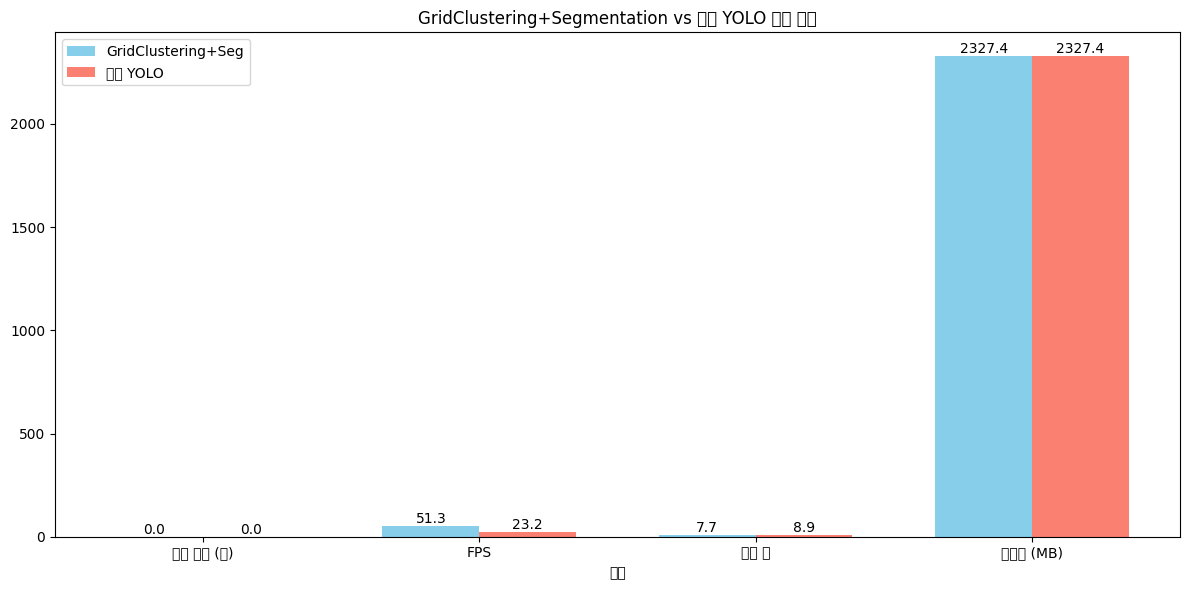


===== 방향 정확도 비교 =====
GridClustering+Seg 트랙 수: 82
순정 YOLO 트랙 수: 55
GridClustering+Seg 평균 방향 정확도: 67.37%
순정 YOLO 평균 방향 정확도: 68.32%


<ipython-input-15-a0e6055baefd>:127: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:127: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:127: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:127: UserWarning: Glyph 47001 (\N{HANGUL SYLLABLE RAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:127: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:127: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-a0e6055baefd>:127: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout

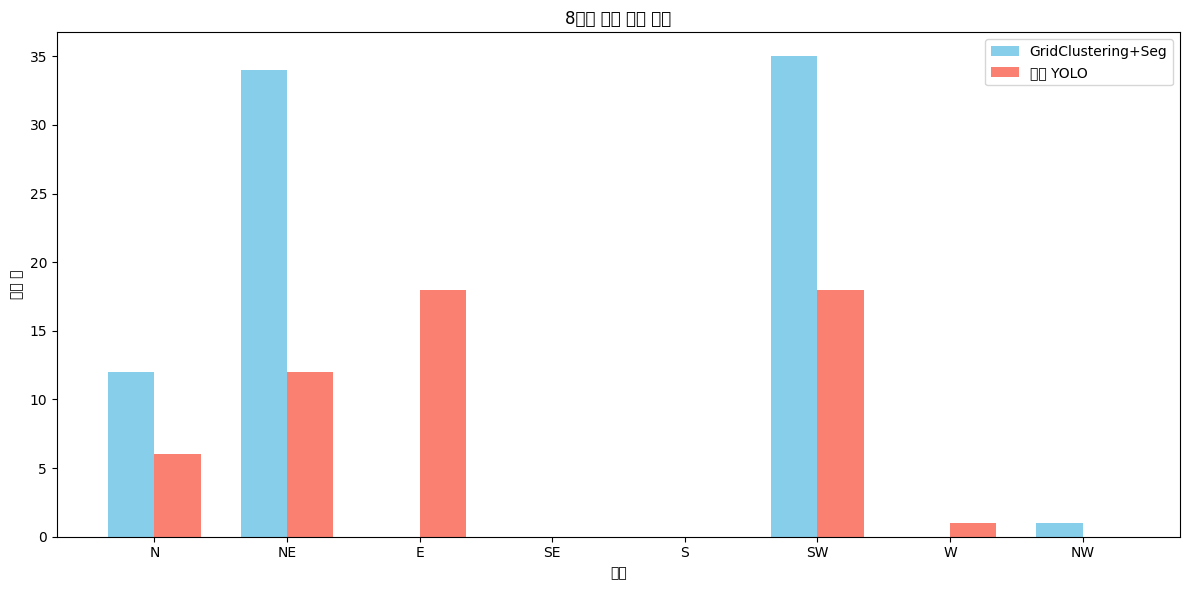


===== 장단점 분석 =====
GridClustering + Segmentation 장점:
1. Scene-Centric 접근: 배경 차분을 통해 움직이는 객체만 효과적으로 추적 가능
2. ROI 자동 설정: 도로와 보행 가능 영역을 자동으로 식별하여 관심 영역(ROI)을 설정, 불필요한 영역에서의 오탐지 감소
3. 그림자/조명 변화 대응: 배경 모델과 함께 사용하면 그림자나 조명 변화에 더 강건한 추적 가능
4. 그리드 기반 클러스터링: 트랙의 시작 위치를 기준으로 그리드 클러스터링을 수행하여 차선별 이동 방향을 자동으로 식별
5. 8방위 방향 시스템: 방향을 8방위로 확장하여 더 정확한 방향 추적 가능

GridClustering + Segmentation 단점:
1. 처리 시간: 배경 차분과 세그멘테이션을 모두 수행하므로 처리 시간이 더 오래 걸림
2. 초기화 시간: ROI 설정 및 배경 모델 안정화에 시간이 필요함
3. 클래스 제한: 사전 학습된 클래스에만 제한적으로 적용 가능

순정 YOLO 장점:
1. 빠른 처리 속도: 단일 패스 모델로 실시간 처리에 적합
2. 초기화 불필요: 별도의 ROI 설정이나 배경 모델 안정화 과정 없이 바로 사용 가능
3. 다양한 클래스: 다양한 객체 클래스를 동시에 검출 가능
4. 높은 정확도: 최신 모델은 높은 검출 정확도를 제공

순정 YOLO 단점:
1. 정적 객체 검출: 움직이지 않는 객체도 검출하여 오탐지 가능성 증가
2. ROI 제한 없음: 관심 영역 외의 객체도 모두 검출하여 불필요한 처리 증가
3. 그림자/조명 변화 취약: 배경 차분 없이는 그림자나 조명 변화에 취약할 수 있음
4. Scene-Centric 접근 부재: 장면 전체를 이해하는 대신 개별 객체 중심으로 접근

===== 결론 =====
GridClustering의 Scene-Centric 접근 방식과 순정 YOLO 비교 결과:
1. GridClustering + Segmentation은 움직이는 객체만 효과적으로 추적하여 정적 객체로 인한

In [17]:
def main():
    # 영상 파일 경로 입력
    video_path = input("영상 파일 경로를 입력하세요: ")

    # 최대 프레임 수 설정 (처리 시간 단축을 위해)
    max_frames = int(input("처리할 최대 프레임 수를 입력하세요 (전체 프레임을 처리하려면 0 입력): "))
    if max_frames <= 0:
        max_frames = None

    # 비교 실험 실행
    print("\n비교 실험을 시작합니다. 이 작업은 시간이 오래 걸릴 수 있습니다...")
    results = compare_tracking_methods(video_path, max_frames)

    if results:
        # 결과 시각화 및 분석
        seg_df, yolo_df = visualize_comparison_results(results)

        print("\n===== 결과 파일 =====")
        print("1. segmentation_tracking.mp4 - GridClustering + Segmentation 기반 트래킹 결과 영상")
        print("2. yolo_tracking.mp4 - 순정 YOLO 기반 트래킹 결과 영상")
        print("3. comparison.mp4 - 두 방식의 비교 영상")
        print("4. segmentation_direction_accuracy.csv - GridClustering + Segmentation 방향 정확도 데이터")
        print("5. yolo_direction_accuracy.csv - 순정 YOLO 방향 정확도 데이터")

        # 방향 정확도 데이터 확인
        print("\nGridClustering + Segmentation 방향 정확도 데이터 (상위 5개):")
        print(seg_df.head())

        print("\n순정 YOLO 방향 정확도 데이터 (상위 5개):")
        print(yolo_df.head())

if __name__ == "__main__":
    main()